# Zápočtový úkol - HEUR
## Sebastian Lorenz
## 21.5.2019
***
# Implementace nového typu křížení v GO a ladění parametrů na spojité 3D Rastriginově funkci

Nový typ křížení: potomek je aritmetickým průměrem rodičů

Rastriginova funkce (2D vyobrazení):
<img src="rast.gif">
$f(x)=10*n+sum(x(i)^2-10*cos(2*pi*x(i))), i=1:n; -5.12<=x(i)<=5.12$

$n$ je počet dimenzí (v našem případě 3)

Minimum = 0 leží v počátku souřadnic.

Toleranci pro nalezení minima jsem zvolil eps=0,5 (absolutní minimum je $0$ a všechny ostatní lokální minima jsou $>1$, tzn. že pokud dojde ke splnění odmínky, tak víme, že se nacházíme v nejnižším kalíšku).

Optimalizované parametry:
- počet jedinců v první generaci $N$ 
- počet jedinců v druhé generaci $M=N*M_c$
- typ křížení (4 druhy: 3 z hodiny + 1 jeden nový)
- parametr $r$ v Cauchyho mutaci
***

## Implementace průměrového křížení:
~~~~{.python}
class MeanChild(Crossover):

    def __init__(self):
        pass

    def crossover(self, x, y):

        if is_integer(x):
            z = np.array(int(round((x+y)/2)), dtype=x.dtype)
        else:
            z = np.array((x+y)/2, dtype=x.dtype)
        return z
~~~~

## Implementace Rastriginovy funkce:
~~~~{.python}
from objfun import ObjFun
import numpy as np


class Rastrigin(ObjFun):
    """
    Rastrigin's function
    
    """

    def __init__(self, n, eps=0.01):
        self.fstar = 0 + eps
        self.n = n
        self.a = -5.12*np.ones(self.n, dtype=np.float64)
        self.b = 5.12*np.ones(self.n, dtype=np.float64)

    def generate_point(self):
        return np.array([np.random.uniform(self.a[i], self.b[i]) for i in np.arange(self.n)], dtype=np.float64)

    def evaluate(self, x):
        return 10*self.n + np.sum([x[i] ** 2 -10*np.cos(2*3.1415926*x[i]) for i in range(self.n)])
~~~~

***
## Nejdžíve naleznu nejlepší kombinaci typu křížení s parametrem r v Cauchyho mutaci:

In [1]:
# přidání src složky do cesty
import sys
import os
pwd = %pwd
sys.path.append(os.path.join('src'))

%load_ext autoreload
%autoreload 2

In [2]:
# načtení potřebných knihoven
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from timeit import default_timer as timer

In [3]:
# funkce pro genetickou optimalizaci
from heur_aux import Correction, MirrorCorrection, ExtensionCorrection, CauchyMutation
from heur_go_Lorenz import GeneticOptimization, Crossover, MeanChild, UniformMultipoint, RandomCombination

In [4]:
# vygenerování funkce Rastrigin
from objfun_rastrigin_Lorenz import Rastrigin
rast = Rastrigin(n=3,eps=0.5)

Pomocí malých jednoduchých 1D testů na pár bězích (cca 10) jsem si určil, že by mohly být výhodné následující parametry:
- počet jedinců v první generaci: $N=10$
- počet jedinců v druhé generaci: $M=N*3$
- maximální počet vyhodnocení fce: $maxeval = 35000$
- teploty v simulovaném žíhání: $T_1=0,1$, $T_2=1$

Počet běhů nastavuju 100 z důvodu výpočetní náročnosti.

In [5]:
# nastavím parametry testování
NUM_RUNS = 100
maxeval = 35000
Cauchy_r = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
N = 10 # = [1, 2, 5, 10, 20, 50, 100, 200]         # bude testováno v pozdějším testu
M_coeff = 3 # =[2, 3, 4, 6, 8, 10, 20, 50, 100]    # bude testováno v pozdějším testu

In [6]:
# funkce prvního experimentu
def experiment_go(of, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, crossover,r):
    results = []
    heur_name = 'GO_cross_{}_mut_{}'.format(crossover['name'],r)
    for i in tqdm_notebook(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, 
                                     mutation=mutation, crossover=crossover['crossover']).search()
        result['run'] = i
        result['cross'] = crossover['name']
        result['cauchy_par'] = r
        result['heur'] = heur_name
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'cross', 'cauchy_par', 'best_x', 'best_y', 'neval'])

In [7]:
# spuštění experimentu
results = pd.DataFrame()

crossovers = [
    {'crossover': Crossover(), 'name': 'mix'},
    {'crossover': UniformMultipoint(1), 'name': 'uni'},
    {'crossover': RandomCombination(), 'name': 'rnd'},
    {'crossover': MeanChild(), 'name': 'mch'}
]

start = timer();
for crossover in crossovers:
    for rr in Cauchy_r:
        mutation = CauchyMutation(r=rr, correction=MirrorCorrection(rast))
        res = experiment_go(of=rast, maxeval=maxeval, num_runs=NUM_RUNS, N=N, M=N*M_coeff, Tsel1=0.1, Tsel2=1, 
                            mutation=mutation, crossover=crossover,r = rr)
        results = pd.concat([results, res], axis=0)
end = timer();
print(end - start) # in seconds


7804.5536428000005


První test zabral 2h a 10min.

In [48]:
# uložení výsledků do pickle formátu
results.to_pickle('results1.pkl')
#results = pd.read_pickle('results1.pkl')
results.head()

,heur,run,cross,cauchy_par,best_x,best_y,neval
0,GO_cross_mix_mut_0.001,0,mix,0.001,"[9.324916002562134e-05, -0.0001082997287751297...",0.994966,inf
1,GO_cross_mix_mut_0.001,1,mix,0.001,"[-6.932082647814752e-05, -0.9950291122744481, ...",0.994961,inf
2,GO_cross_mix_mut_0.001,2,mix,0.001,"[-7.1577225417840395e-06, 0.9949580917343388, ...",0.994959,inf
3,GO_cross_mix_mut_0.001,3,mix,0.001,"[5.717451086972858e-05, -3.702164055408019e-05...",0.994960,inf
4,GO_cross_mix_mut_0.001,4,mix,0.001,"[-0.00013797731723386164, 0.0497223847337791, ...",0.486849,7221.000000


In [9]:
# parametry k vyhodnocení
def rel(x): # REL=m/q kde m počet úspěšných běhů a q je celkový počet běhů
    return len([n for n in x if n < np.inf])/len(x)
def mne(x): # průměrný počet vyhodnocení testovací funkce v rámci úspěšných běhů
    return np.mean([n for n in x if n < np.inf])
def feo(x): # Feoktisovo kritérium: FEO = MNE/REL
    return mne(x)/rel(x)

In [49]:
# Sestavení kontingenční tabulky s výsledky
results_pivot = results.pivot_table(
    index=['cross', 'cauchy_par', 'heur'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='feo').head()
# vykresleni nejlepsich kombinací podle Feoktisova kritéria

,cross,cauchy_par,heur,feo,mne,rel
28,rnd,0.10,GO_cross_rnd_mut_0.1,2043.78,2043.78,1.0
17,mix,0.10,GO_cross_mix_mut_0.1,2256.04,2256.04,1.0
5,mch,0.05,GO_cross_mch_mut_0.05,2268.25,2268.25,1.0
6,mch,0.10,GO_cross_mch_mut_0.1,2345.28,2345.28,1.0
39,uni,0.10,GO_cross_uni_mut_0.1,2449.65,2449.65,1.0


<IPython.core.display.Javascript object>


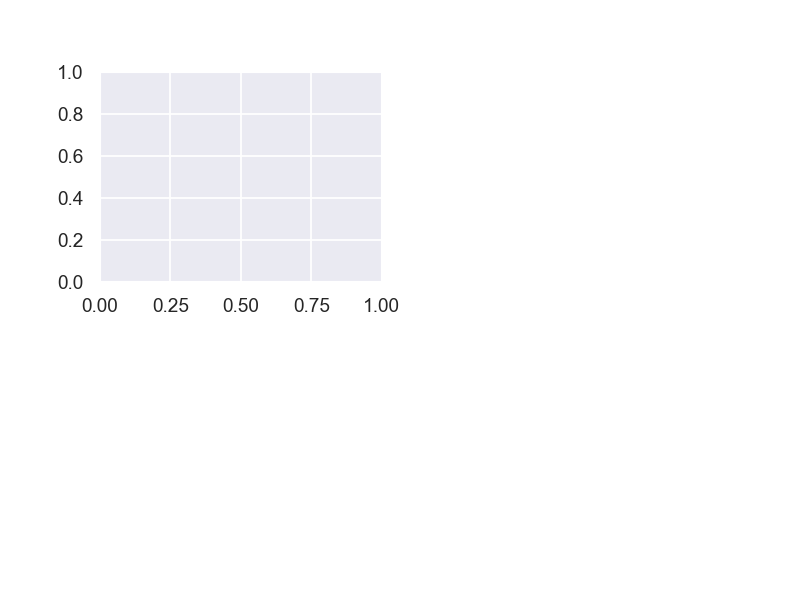

<IPython.core.display.Javascript object>


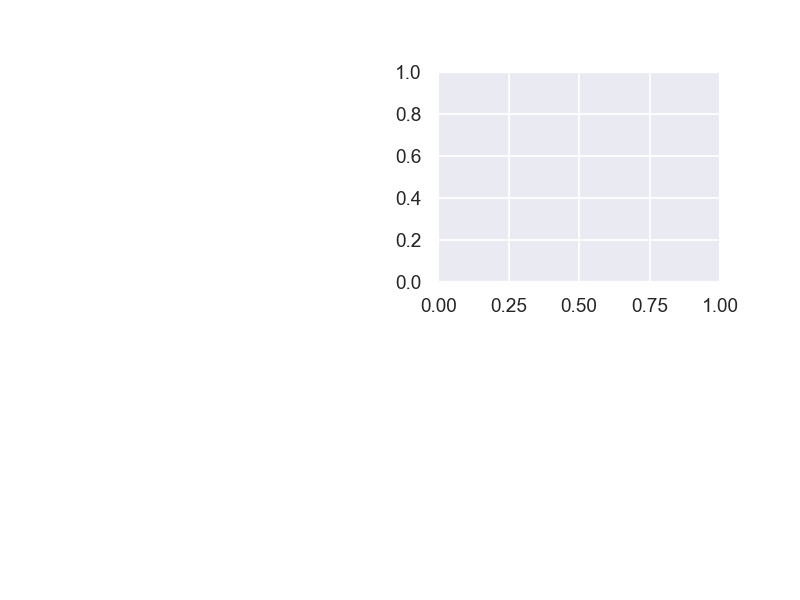

<IPython.core.display.Javascript object>


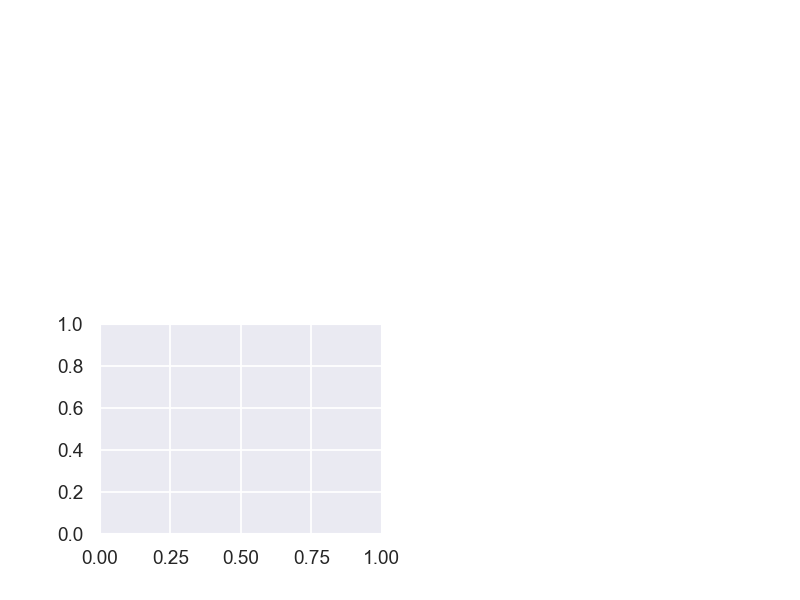

<IPython.core.display.Javascript object>


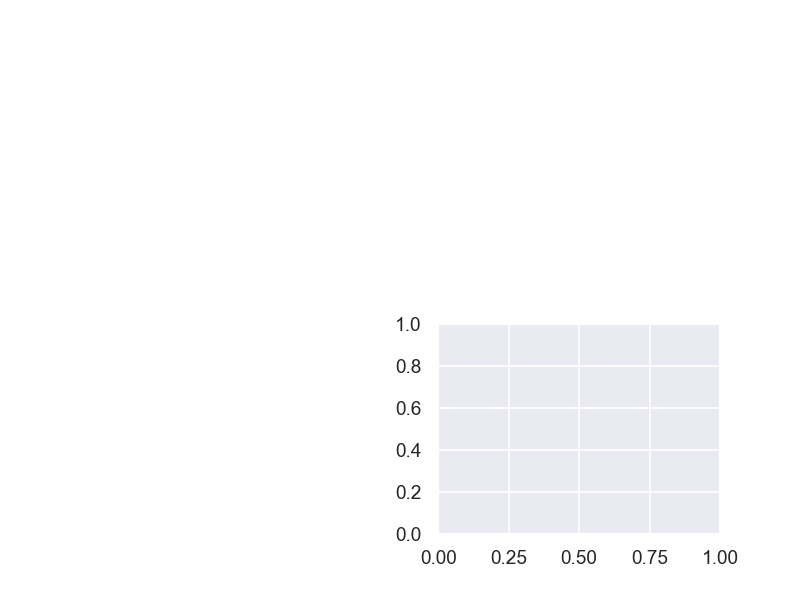

<IPython.core.display.Javascript object>


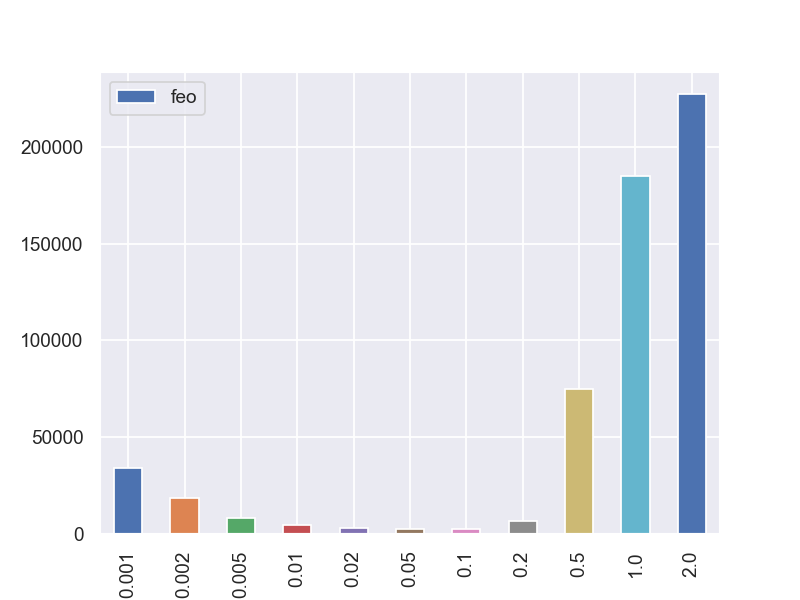

In [60]:
# nejlepší výsledky pro jednotlivé druhy křížení
#results_pivot.sort_values(by=['cross','feo'])
plt.subplot(2,2,1)
mch_r = results_pivot[results_pivot['cross']=='mch']
mch_r.plot(x = 'cauchy_par', y = 'feo', kind='bar')
plt.subplot(2,2,2)
rnd_r = results_pivot[results_pivot['cross']=='rnd']
rnd_r.plot(x = 'cauchy_par', y = 'feo', kind='bar')
plt.subplot(2,2,3)
mix_r = results_pivot[results_pivot['cross']=='mix']
mix_r.plot(x = 'cauchy_par', y = 'feo', kind='bar')
plt.subplot(2,2,4)
uni_r = results_pivot[results_pivot['cross']=='uni']
uni_r.plot(x = 'cauchy_par', y = 'feo', kind='bar')

Závěry z prvního testu:
- jde vidět, že na volbě druhu mutace až tolik nezáleží, rozdíly ve FEO nejsou nijak markantní
- nejlépe však dopadlo RandomCombination(), tak ho zvolíme i do dalších testů
- moje nově implementované průměrování nijak nezaostává za ostatníma, ale ani neni nejlepší :-(
- podstatně více však záleží na správné volbě parametru r v Cauchyově křížení
- dá se říct, že pro všechny druhy křížení je výhodná volba $r=0,1$

***
## Hledání nejlepší kombinace N a M pro RandomCombination s r=0,1 (C.M.)
Pro tuto kombinaci lze pouít menší maxeval

In [32]:
# nastavím parametry testování
NUM_RUNS = 10
maxeval = 5000
N = [1, 2, 5, 10, 20, 50, 100, 200]
M_coeff = [2, 3, 4, 6, 8, 10, 20, 50, 100]
rr = 0.1;
mutation = CauchyMutation(r=rr, correction=MirrorCorrection(rast))
crossover = RandomCombination()

In [33]:
# funkce druhého experimentu
def experiment2_go(of, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, crossover,r):
    results = []
    heur_name = 'GO_N{}_M{}'.format(N,M)
    for i in tqdm_notebook(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, 
                                     mutation=mutation, crossover=crossover).search()
        result['run'] = i
        result['N'] = N
        result['M'] = M
        result['heur'] = heur_name
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'M', 'best_x', 'best_y', 'neval'])

In [34]:
# spuštění druhého experimentu
results2 = pd.DataFrame()

start = timer();
for n in N:
    for mc in M_coeff:
        m = n*mc;
        res = experiment2_go(of=rast, maxeval=maxeval, num_runs=NUM_RUNS, N=n, M=m, Tsel1=0.1, Tsel2=1, 
                            mutation=mutation, crossover=crossover,r = rr)
        results2 = pd.concat([results2, res], axis=0)
end = timer();
print(end - start) # in seconds


336.7439589000023


Test trval 6min.

In [35]:
# uložení výsledků do pickle formátu
results2.to_pickle('results2.pkl')
# results2 = pd.read_pickle(results2.pkl)
results2.head()

,heur,run,N,M,best_x,best_y,neval
0,GO_N1_M2,0,1,2,"[-0.06469225903481135, 0.04486396212193089, -0...",1.521146,inf
1,GO_N1_M2,1,1,2,"[0.026477397717680873, 1.0814340785653886, -0....",4.407285,inf
2,GO_N1_M2,2,1,2,"[0.9894881192026661, 0.9020143023400484, 0.975...",4.721719,inf
3,GO_N1_M2,3,1,2,"[-0.015236701600711555, -0.9748776103867369, -...",3.164395,inf
4,GO_N1_M2,4,1,2,"[0.01927921757512152, -0.0016708231775881544, ...",2.564382,inf


In [37]:
# Sestavení kontingenční tabulky s výsledky
results_pivot2 = results2.pivot_table(
    index=['N', 'M', 'heur'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot2 = results_pivot2.reset_index()
results_pivot2.sort_values(by='feo').head()
# vykresleni nejlepsich kombinací podle Feoktisova kritéria

,N,M,heur,feo,mne,rel
22,5,40,GO_N5_M40,1593.800000,1593.800000,1.0
28,10,30,GO_N10_M30,1679.000000,1679.000000,1.0
19,5,15,GO_N5_M15,1954.320988,1758.888889,0.9
21,5,30,GO_N5_M30,2015.300000,2015.300000,1.0
20,5,20,GO_N5_M20,2034.600000,2034.600000,1.0


Závěry z druhého testu:
- nejlépe vychází kombinace $N=5, M=40$ a $N=10,M=30$, tkaže v prvním testu byly předpokládány správné hodnoty
- bohužel ale (z časových důvodů) bylo použito málo testovacích běhů (10) pro každou kombinaci, tak výsledky nejsou uplně přesné

In [61]:
from heur_sg import ShootAndGo
from objfun_sumsin import SumSin

In [64]:
def experiment_rs(of, maxeval, num_runs):
    method = 'RS'
    results = []
    for i in tqdm_notebook(range(num_runs), 'Random_shooting'):
        result = ShootAndGo(of, maxeval=maxeval, hmax=0).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'Random_shooting'
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'best_x', 'best_y', 'neval'])

In [71]:
res3 = experiment_rs(of=rast, maxeval=1000000, num_runs=10)

In [72]:
res3

,heur,run,best_x,best_y,neval
0,Random_shooting,0,"[-0.9895335780697883, -0.013853961043468033, 0...",1.177625,inf
1,Random_shooting,1,"[0.0050402393409259005, -0.006241918416044712,...",0.528775,inf
2,Random_shooting,2,"[-0.03772794882280994, 0.0281201322054212, 0.0...",0.495164,8.678720e+05
3,Random_shooting,3,"[0.053204573299471924, 0.01708198608981437, -0...",0.618264,inf
4,Random_shooting,4,"[-0.04439708513217511, -0.038445457346503176, ...",0.689409,inf
5,Random_shooting,5,"[0.03138923354450274, 0.03976874675004716, 0.0...",0.519796,inf
6,Random_shooting,6,"[-0.022209331938230825, 0.038895745462553144, ...",0.401635,6.437050e+05
7,Random_shooting,7,"[-0.05123911419660221, 0.010703161209502099, 0...",0.730671,inf
8,Random_shooting,8,"[0.00046061706723854456, 0.0025851994685872626...",0.052131,8.160160e+05
9,Random_shooting,9,"[-0.020570036843787776, 0.041383915901871404, ...",0.631135,inf


In [74]:
results_pivot3 = res3.pivot_table(
    index=['heur'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot3 = results_pivot3.reset_index()
results_pivot3

,heur,feo,mne,rel
0,Random_shooting,2.586214e+06,775864.333333,0.3


Vidíme, že Random Shooting má oproti mé vyladěné metodě o 3 řády horší FEO.

Ono je to logické, jelikož se musíme trefit do oblasti , která zabírá pouze 1,5*10^-8 celkového objemu (tzn. průměrně bychom měli střílet 66milion-krát)